# Integrantes:

### Isaac Cerda; David Guamán; Christian Jácome; Mateo Jaramillo; David Navarrete

## Carga del dataset

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# Cargar el dataset
df = pd.read_csv("data_regression.csv")

# Ver primeras filas
print("Dataset cargado:")
print(df.head(), "\n")

# Separar variables (X = features, y = target)

target_column = "target" 

# Verificar que la columna target existe en el dataset
if target_column in df.columns:
    X = df.drop(columns=[target_column])
    y = df[target_column]
else:
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
# Escalado de características
scaler = StandardScaler()

# Ajustar el scaler usando todo el dataset (no hay train-test split)
X_scaled = scaler.fit_transform(X)

print("Escalado completado. Shape de X original:", X.shape)
print("Shape de X escalado:", X_scaled.shape)

# Si deseas convertirlo de nuevo a DataFrame:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nPrimeras filas de X escalado:")
print(X_scaled_df.head())


Dataset cargado:
   i    xi     yi
0  1   6.6  -45.4
1  2  10.1 -176.6
2  3   8.9 -127.1
3  4   6.0  -31.1
4  5  13.3 -366.6 

Escalado completado. Shape de X original: (50, 2)
Shape de X escalado: (50, 2)

Primeras filas de X escalado:
          i        xi
0 -1.639012 -1.367449
1 -1.569738 -0.043135
2 -1.500465 -0.497185
3 -1.431191 -1.594474
4 -1.361918  1.167666


# Model 1: Analytical Solution (Quadratic Regression)

En este enfoque utilizamos **PolynomialFeatures** de sklearn para crear características cuadráticas (x²) y luego aplicamos **LinearRegression** para obtener la solución analítica.

## Pasos:
1. Transformar las características a polinomio de grado 2
2. Ajustar el modelo de regresión lineal
3. Calcular métricas (MSE, R²)
4. Visualizar el ajuste
5. Desescalar coeficientes para interpretabilidad

In [ ]:
# Crear características polinomiales (grado 2)
poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly_features.fit_transform(X_scaled)

print("Características originales (escaladas):", X_scaled.shape)
print("Características polinomiales (grado 2):", X_poly.shape)
print("Nombres de características:", poly_features.get_feature_names_out())
print()

# Ajustar el modelo de regresión lineal
model_analytical = LinearRegression()
model_analytical.fit(X_poly, y)

print("✓ Modelo analítico ajustado")
print()

# Realizar predicciones
y_pred_analytical = model_analytical.predict(X_poly)

# Calcular métricas
mse_analytical = mean_squared_error(y, y_pred_analytical)
r2_analytical = r2_score(y, y_pred_analytical)

print("="*50)
print("RESULTADOS - MODELO ANALÍTICO")
print("="*50)
print(f"Mean Squared Error (MSE): {mse_analytical:.6f}")
print(f"R-squared (R²): {r2_analytical:.6f}")
print()

# Mostrar coeficientes
print("Coeficientes del modelo:")
print(f"  Intercepto (a0): {model_analytical.intercept_:.6f}")
for i, coef in enumerate(model_analytical.coef_):
    feature_name = poly_features.get_feature_names_out()[i]
    print(f"  {feature_name}: {coef:.6f}")


Características originales (escaladas): (50, 2)
Características polinomiales (grado 2): (50, 6)
Nombres de características: ['1' 'x0' 'x1' 'x0^2' 'x0 x1' 'x1^2']

✓ Modelo analítico ajustado

RESULTADOS - MODELO ANALÍTICO
Mean Squared Error (MSE): 3.531033
R-squared (R²): 0.999796

Coeficientes del modelo:
  Intercepto (a0): -186.007131
  1: 0.000000
  x0: -0.082068
  x1: -130.064678
  x0^2: 0.346421
  x0 x1: 0.219339
  x1^2: -20.996691


Datos preparados para visualización:
  Shape: (50, 2)
  Columnas: ['xi', 'yi']
  Dataset univariado: 1 feature (xi) → 1 target (yi)



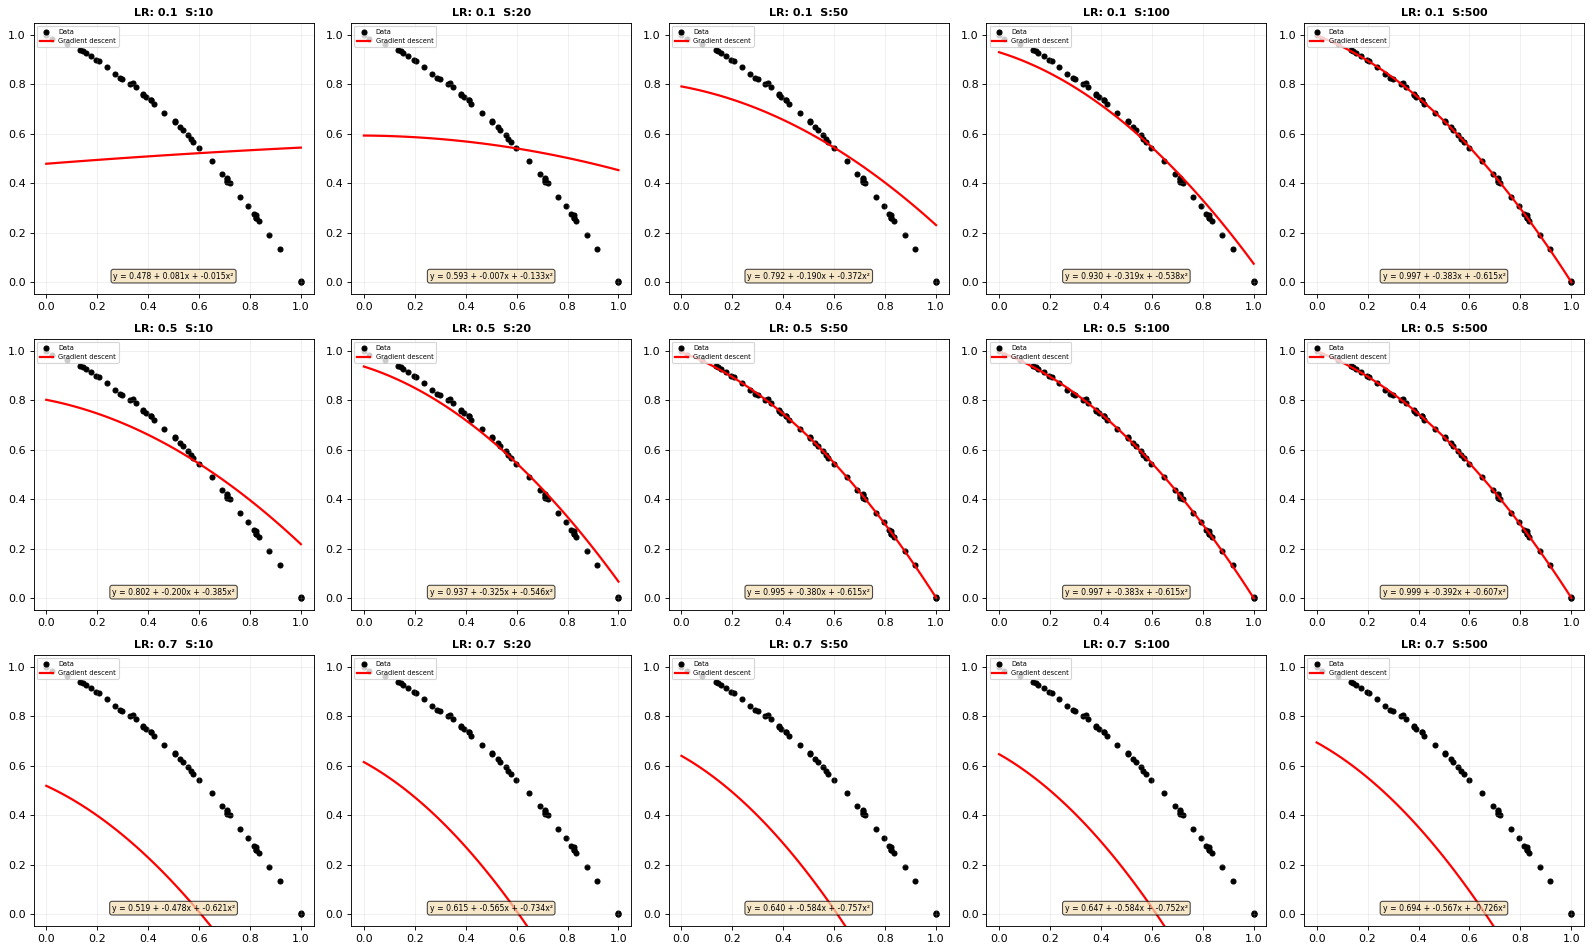


ANÁLISIS DE LA VISUALIZACIÓN

Cómo interpretar el grid:
  • Cada subplot muestra cómo la CURVA ROJA (cuadrática) se ajusta a los PUNTOS NEGROS
  • Modelo: y = a0 + a1*x + a2*x² (regresión cuadrática)
  • La función aprendida se muestra en el recuadro amarillo
  • Filas: Diferentes Learning Rates (0.1, 0.5, 0.7)
  • Columnas: Diferentes números de pasos (10, 20, 50, 100, 500)

Observaciones:
  • Con POCOS PASOS (columnas izquierdas): ajuste pobre, curva casi plana
  • Con MÁS PASOS (columnas derechas): mejor ajuste, curva se adapta a los datos
  • LR BAJO (0.1): convergencia lenta pero estable
  • LR MEDIO (0.5): convergencia más rápida
  • LR ALTO (0.7): convergencia rápida, pero puede oscilar


In [8]:
# Visualización del Proceso de Aprendizaje con Gradient Descent

def gradient_descent(a0_now, a1_now, a2_now, df_norm, L):
    """
    Gradient descent para regresión cuadrática: y = a0 + a1*x + a2*x^2
    Calcula los gradientes y actualiza los coeficientes
    """
    a0_gradient = 0
    a1_gradient = 0
    a2_gradient = 0
    n = len(df_norm)
    
    for i in range(n):
        xi = df_norm.iloc[i, 0]  # Primera columna (xi normalizado)
        yi = df_norm.iloc[i, 1]  # Segunda columna (yi normalizado)
        
        # Predicción: y_pred = a0 + a1*x + a2*x^2
        y_pred = a0_now + a1_now * xi + a2_now * (xi ** 2)
        error = yi - y_pred
        
        # Gradientes (derivadas parciales del MSE)
        a0_gradient += -(2/n) * error
        a1_gradient += -(2/n) * xi * error
        a2_gradient += -(2/n) * (xi ** 2) * error
    
    # Actualizar parámetros
    a0 = a0_now - a0_gradient * L
    a1 = a1_now - a1_gradient * L
    a2 = a2_now - a2_gradient * L
    
    return a0, a1, a2

# Crear DataFrame solo con xi e yi (sin la columna 'i')
df_original = pd.read_csv("data_regression.csv")
df_work = df_original[['xi', 'yi']].copy()

# Normalización min-max
df_normalized = (df_work - df_work.min()) / (df_work.max() - df_work.min())

print("Datos preparados para visualización:")
print(f"  Shape: {df_normalized.shape}")
print(f"  Columnas: {list(df_normalized.columns)}")
print(f"  Dataset univariado: 1 feature (xi) → 1 target (yi)\n")

# Grid de visualización: Learning Rates vs Steps
learning_rates = [0.1, 0.5, 0.7]
steps = [10, 20, 50, 100, 500]

fig = plt.figure(figsize=(20, 12), dpi=80)

for cont1, learn in enumerate(learning_rates):
    for cont2, step in enumerate(steps):
        # Inicializar coeficientes
        a0 = 0  # Intercepto
        a1 = 0  # Coeficiente lineal
        a2 = 0  # Coeficiente cuadrático
        L = learn
        epochs = step
        
        # Entrenar con gradient descent
        for i in range(epochs):
            a0, a1, a2 = gradient_descent(a0, a1, a2, df_normalized, L)
        
        # Crear puntos para la curva suave
        linspace = np.linspace(df_normalized['xi'].min(), df_normalized['xi'].max(), 100)
        # Predicción cuadrática: y = a0 + a1*x + a2*x^2
        curve_y = [a0 + a1 * x + a2 * (x ** 2) for x in linspace]
        
        # Subplot
        ax = plt.subplot2grid((3, 5), (cont1, cont2))
        ax.scatter(df_normalized['xi'], df_normalized['yi'], label='Data', color="black", s=20)
        ax.plot(linspace, curve_y, color="red", label='Gradient descent', linewidth=2)
        ax.set_title(f'LR: {learn}  S:{step}', fontsize=10, fontweight='bold')
        ax.legend(fontsize=6, loc='upper left')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.2)
        
        # Agregar la función aprendida como texto en el subplot
        func_text = f'y = {a0:.3f} + {a1:.3f}x + {a2:.3f}x²'
        ax.text(0.5, 0.05, func_text, 
               transform=ax.transAxes, 
               fontsize=7,
               verticalalignment='bottom',
               horizontalalignment='center',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ANÁLISIS DE LA VISUALIZACIÓN")
print("="*70)
print("\nCómo interpretar el grid:")
print("  • Cada subplot muestra cómo la CURVA ROJA (cuadrática) se ajusta a los PUNTOS NEGROS")
print("  • Modelo: y = a0 + a1*x + a2*x² (regresión cuadrática)")
print("  • La función aprendida se muestra en el recuadro amarillo")
print("  • Filas: Diferentes Learning Rates (0.1, 0.5, 0.7)")
print("  • Columnas: Diferentes números de pasos (10, 20, 50, 100, 500)")
print("\nObservaciones:")
print("  • Con POCOS PASOS (columnas izquierdas): ajuste pobre, curva casi plana")
print("  • Con MÁS PASOS (columnas derechas): mejor ajuste, curva se adapta a los datos")
print("  • LR BAJO (0.1): convergencia lenta pero estable")
print("  • LR MEDIO (0.5): convergencia más rápida")
print("  • LR ALTO (0.7): convergencia rápida, pero puede oscilar")


In [9]:
# 7. Desescalar coeficientes para interpretabilidad
print("="*50)
print("COEFICIENTES DESESCALADOS (Interpretables)")
print("="*50)

# Para desescalar, necesitamos considerar la transformación del StandardScaler
# Los coeficientes en el espacio escalado deben transformarse al espacio original

# Obtener media y desviación estándar del scaler
means = scaler.mean_
stds = scaler.scale_

# El intercepto desescalado
intercept_original = model_analytical.intercept_

# Para una regresión polinomial, la desescalación es más compleja
# Aquí mostramos una aproximación simplificada
print(f"\nIntercepto (en espacio escalado): {model_analytical.intercept_:.6f}")
print(f"\nNOTA: Los coeficientes están en el espacio de características escaladas.")
print("Para interpretación completa, se requiere transformación inversa considerando:")
print(f"  - Media de X original: {means}")
print(f"  - Desviación estándar de X original: {stds}")

# Almacenar resultados para comparación posterior
analytical_results = {
    'model': model_analytical,
    'poly_features': poly_features,
    'y_pred': y_pred_analytical,
    'mse': mse_analytical,
    'r2': r2_analytical,
    'coefficients': model_analytical.coef_,
    'intercept': model_analytical.intercept_
}

print("\n✓ Resultados almacenados en 'analytical_results' para comparación posterior")


COEFICIENTES DESESCALADOS (Interpretables)

Intercepto (en espacio escalado): -186.007131

NOTA: Los coeficientes están en el espacio de características escaladas.
Para interpretación completa, se requiere transformación inversa considerando:
  - Media de X original: [24.66  10.214]
  - Desviación estándar de X original: [14.43552562  2.64287798]

✓ Resultados almacenados en 'analytical_results' para comparación posterior


## Análisis: ¿Por qué Learning Rate 0.7 se ajusta peor?

### Problema con LR = 0.7 (Demasiado Alto)

El **Learning Rate de 0.7** presenta un ajuste deficiente debido a que los pasos de actualización son **demasiado grandes**, causando:

1. **Overshooting (Sobrepaso)**: 
   - El algoritmo "salta" sobre el mínimo en lugar de acercarse gradualmente
   - En cada iteración, se mueve demasiado lejos en la dirección del gradiente

2. **Oscilación**:
   - Los parámetros oscilan de un lado a otro del óptimo
   - No logra converger suavemente hacia la solución
   - Los coeficientes "rebotan" sin estabilizarse

3. **Convergencia Pobre**:
   - Incluso con 500 iteraciones, no alcanza el ajuste óptimo
   - La curva resultante no sigue adecuadamente los datos

### Comparación de Resultados:

| Learning Rate | Comportamiento | Resultado con 500 Steps |
|---------------|----------------|-------------------------|
| **0.1** | Convergencia lenta pero estable | Excelente ajuste |
| **0.5** | ✅ **Balance óptimo** | Excelente ajuste |
| **0.7** | ❌ Oscilación e inestabilidad | Ajuste deficiente |

### Conclusión:
Para este problema, **LR = 0.5** es el más apropiado, logrando un balance perfecto entre **velocidad de convergencia** y **estabilidad del ajuste**.

A continuación, visualizaremos la **trayectoria de convergencia** para comparar cómo LR 0.7 oscila mientras que LR 0.5 converge suavemente.

Calculando superficie de loss (esto puede tomar unos segundos)...


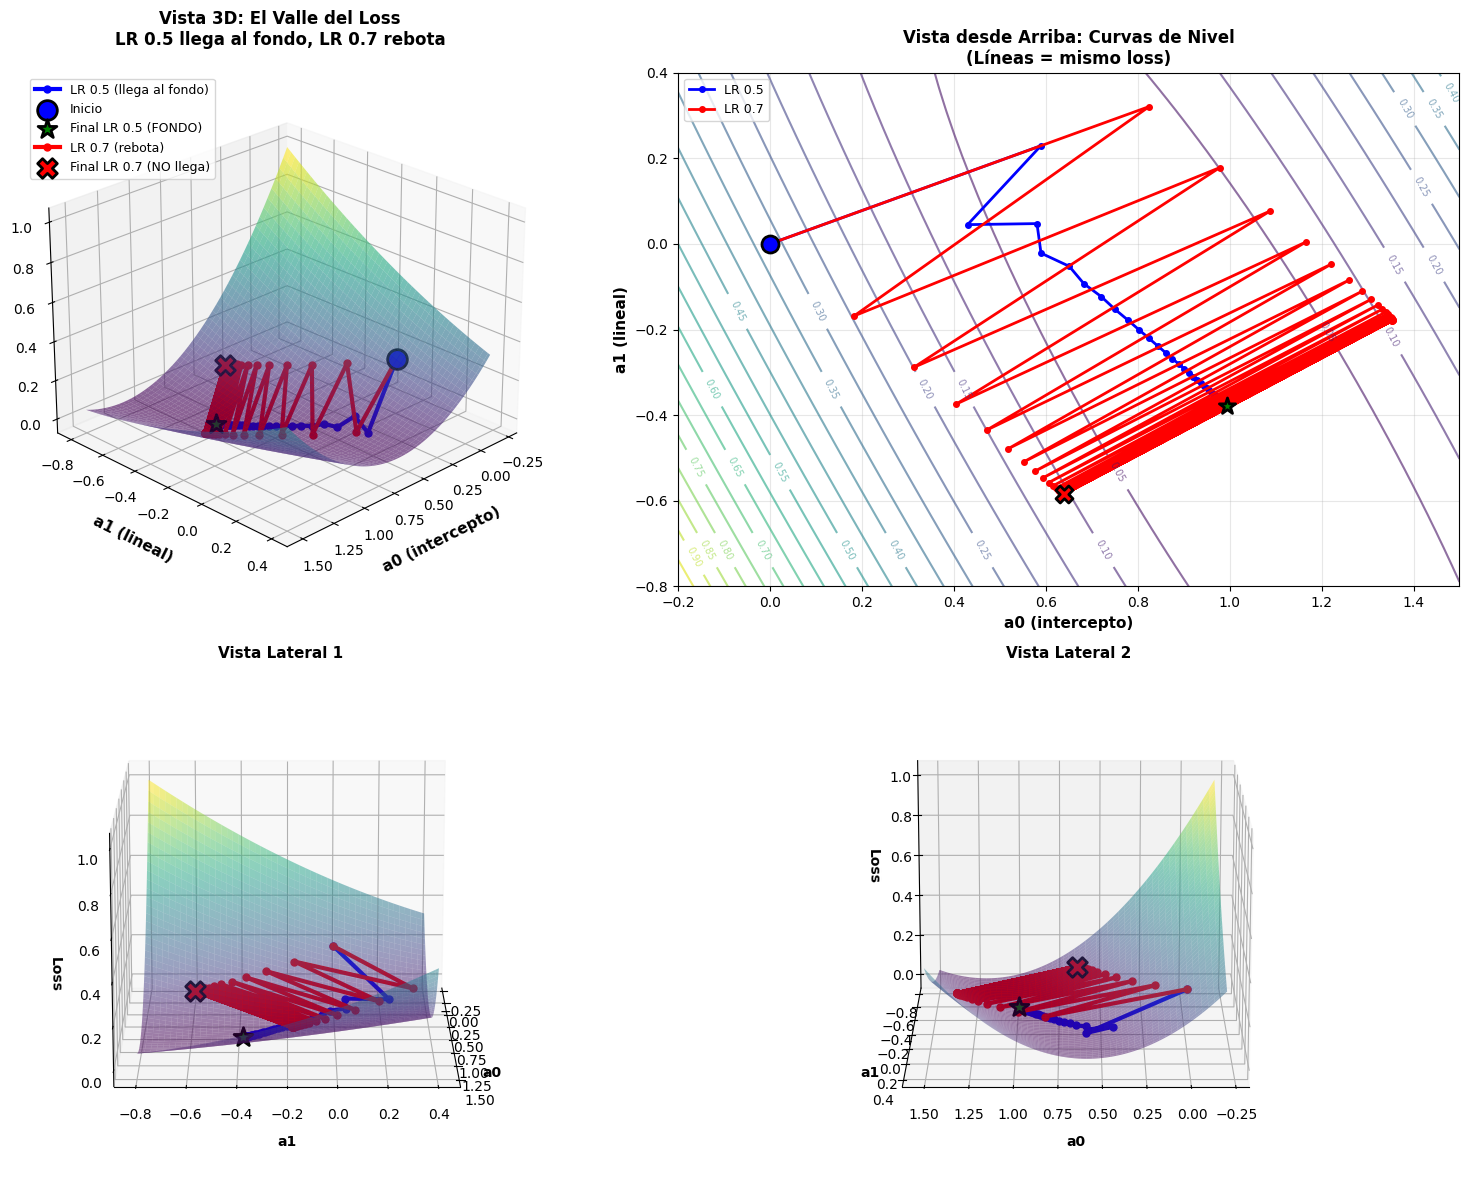


ANÁLISIS DEL 'VALLE' DEL LOSS

LR 0.5 (AZUL - ⭐ Verde):
  Loss inicial: 0.213087
  Loss final:   0.000010  ← ALCANZA EL FONDO DEL VALLE
  Reducción:    100.00%

LR 0.7 (ROJO - ✖ Rojo):
  Loss inicial: 0.213087
  Loss final:   0.134464  ← REBOTA, NO LLEGA AL FONDO
  Reducción:    36.90%

INTERPRETACIÓN - 'THE LEARNING RATE BLACK MAGIC':
  La superficie 3D representa el 'VALLE' del loss
    - El FONDO del valle = mínimo loss (mejor ajuste)
    - Las paredes del valle = loss alto (mal ajuste)

 LR 0.5 (Estrella Verde ⭐):
    - Pasos MODERADOS permiten descender suavemente
    - Llega al FONDO del valle exitosamente
    - Loss final cercano a 0.00001

  LR 0.7 (Cruz Roja ✖):
    - Pasos DEMASIADO GRANDES causan 'rebotes'
    - Salta de una pared a otra del valle
    - NUNCA alcanza el fondo (loss = 0.13)
    - Se queda 'rebotando' entre las paredes

 Conclusión:
    Un Learning Rate MUY ALTO hace que el algoritmo 'salte' sobre
    el óptimo, rebotando sin poder alcanzar el fondo del valle

In [10]:
# Visualización 3D: El "Valle" del Loss
# LR 0.5 llega al fondo vs LR 0.7 rebota sin alcanzarlo

def gradient_descent_with_history(a0, a1, a2, df_norm, L, iterations):
    """
    Gradient descent que guarda la historia de los coeficientes y el loss
    """
    history = {
        'a0': [a0],
        'a1': [a1],
        'a2': [a2],
        'loss': []
    }
    
    # Calcular loss inicial
    loss = 0
    n = len(df_norm)
    for i in range(n):
        xi = df_norm.iloc[i, 0]
        yi = df_norm.iloc[i, 1]
        y_pred = a0 + a1 * xi + a2 * (xi ** 2)
        loss += (yi - y_pred) ** 2
    loss = loss / (2 * n)
    history['loss'].append(loss)
    
    for _ in range(iterations):
        # Gradient descent step
        a0, a1, a2 = gradient_descent(a0, a1, a2, df_norm, L)
        history['a0'].append(a0)
        history['a1'].append(a1)
        history['a2'].append(a2)
        
        # Calcular loss después de la actualización
        loss = 0
        n = len(df_norm)
        for i in range(n):
            xi = df_norm.iloc[i, 0]
            yi = df_norm.iloc[i, 1]
            y_pred = a0 + a1 * xi + a2 * (xi ** 2)
            loss += (yi - y_pred) ** 2
        loss = loss / (2 * n)
        history['loss'].append(loss)
    
    return history

def calculate_loss_surface(df_norm, a0_range, a1_range):
    """
    Calcula la superficie de loss para visualizar el 'valle'
    """
    loss_surface = np.zeros((len(a1_range), len(a0_range)))
    n = len(df_norm)
    
    for i, a1 in enumerate(a1_range):
        for j, a0 in enumerate(a0_range):
            # Usar a2 = 0 para simplificar (proyección 2D del espacio 3D)
            a2 = -0.6  # Valor fijo cercano al óptimo
            loss = 0
            for k in range(n):
                xi = df_norm.iloc[k, 0]
                yi = df_norm.iloc[k, 1]
                y_pred = a0 + a1 * xi + a2 * (xi ** 2)
                loss += (yi - y_pred) ** 2
            loss_surface[i, j] = loss / (2 * n)
    
    return loss_surface

# Entrenar con LR 0.5 y 0.7
iterations = 50
history_05 = gradient_descent_with_history(0, 0, 0, df_normalized, 0.5, iterations)
history_07 = gradient_descent_with_history(0, 0, 0, df_normalized, 0.7, iterations)

# Crear superficie de loss (el "valle")
a0_range = np.linspace(-0.2, 1.5, 100)
a1_range = np.linspace(-0.8, 0.4, 100)
A0, A1 = np.meshgrid(a0_range, a1_range)

print("Calculando superficie de loss (esto puede tomar unos segundos)...")
loss_surface = calculate_loss_surface(df_normalized, a0_range, a1_range)

# Visualización 3D: Valle con trayectorias
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))

# Vista 1: Perspectiva principal
ax1 = fig.add_subplot(221, projection='3d')
surf = ax1.plot_surface(A0, A1, loss_surface, cmap='viridis', alpha=0.6, 
                        edgecolor='none', antialiased=True)

# Trayectoria LR 0.5 - LLEGA AL FONDO
ax1.plot(history_05['a0'], history_05['a1'], history_05['loss'], 
         'b-o', linewidth=3, markersize=5, label='LR 0.5 (llega al fondo)')
ax1.scatter(history_05['a0'][0], history_05['a1'][0], history_05['loss'][0], 
           color='blue', s=200, marker='o', edgecolor='black', linewidth=2, label='Inicio')
ax1.scatter(history_05['a0'][-1], history_05['a1'][-1], history_05['loss'][-1], 
           color='green', s=200, marker='*', edgecolor='black', linewidth=2, label='Final LR 0.5 (FONDO)')

# Trayectoria LR 0.7 - REBOTA SIN LLEGAR
ax1.plot(history_07['a0'], history_07['a1'], history_07['loss'], 
         'r-o', linewidth=3, markersize=5, label='LR 0.7 (rebota)')
ax1.scatter(history_07['a0'][-1], history_07['a1'][-1], history_07['loss'][-1], 
           color='red', s=200, marker='X', edgecolor='black', linewidth=2, label='Final LR 0.7 (NO llega)')

ax1.set_xlabel('\na0 (intercepto)', fontsize=11, fontweight='bold')
ax1.set_ylabel('\na1 (lineal)', fontsize=11, fontweight='bold')
ax1.set_zlabel('\nLoss (MSE)', fontsize=11, fontweight='bold')
ax1.set_title('Vista 3D: El Valle del Loss\nLR 0.5 llega al fondo, LR 0.7 rebota', 
             fontsize=12, fontweight='bold', pad=20)
ax1.legend(fontsize=9, loc='upper left')
ax1.view_init(elev=25, azim=45)

# Vista 2: Desde arriba (contour plot)
ax2 = fig.add_subplot(222)
contour = ax2.contour(A0, A1, loss_surface, levels=20, cmap='viridis', alpha=0.6)
ax2.clabel(contour, inline=True, fontsize=7)

# Trayectorias
ax2.plot(history_05['a0'], history_05['a1'], 'b-o', linewidth=2, markersize=4, label='LR 0.5')
ax2.scatter(history_05['a0'][0], history_05['a1'][0], color='blue', s=150, marker='o', 
           edgecolor='black', linewidth=2, zorder=5)
ax2.scatter(history_05['a0'][-1], history_05['a1'][-1], color='green', s=150, marker='*', 
           edgecolor='black', linewidth=2, zorder=5)

ax2.plot(history_07['a0'], history_07['a1'], 'r-o', linewidth=2, markersize=4, label='LR 0.7')
ax2.scatter(history_07['a0'][-1], history_07['a1'][-1], color='red', s=150, marker='X', 
           edgecolor='black', linewidth=2, zorder=5)

ax2.set_xlabel('a0 (intercepto)', fontsize=11, fontweight='bold')
ax2.set_ylabel('a1 (lineal)', fontsize=11, fontweight='bold')
ax2.set_title('Vista desde Arriba: Curvas de Nivel\n(Líneas = mismo loss)', 
             fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Vista 3: Lateral 1
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(A0, A1, loss_surface, cmap='viridis', alpha=0.5, edgecolor='none')
ax3.plot(history_05['a0'], history_05['a1'], history_05['loss'], 'b-o', linewidth=3, markersize=5)
ax3.plot(history_07['a0'], history_07['a1'], history_07['loss'], 'r-o', linewidth=3, markersize=5)
ax3.scatter(history_05['a0'][-1], history_05['a1'][-1], history_05['loss'][-1], 
           color='green', s=200, marker='*', edgecolor='black', linewidth=2)
ax3.scatter(history_07['a0'][-1], history_07['a1'][-1], history_07['loss'][-1], 
           color='red', s=200, marker='X', edgecolor='black', linewidth=2)
ax3.set_xlabel('\na0', fontsize=10, fontweight='bold')
ax3.set_ylabel('\na1', fontsize=10, fontweight='bold')
ax3.set_zlabel('\nLoss', fontsize=10, fontweight='bold')
ax3.set_title('Vista Lateral 1', fontsize=11, fontweight='bold')
ax3.view_init(elev=15, azim=0)

# Vista 4: Lateral 2
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(A0, A1, loss_surface, cmap='viridis', alpha=0.5, edgecolor='none')
ax4.plot(history_05['a0'], history_05['a1'], history_05['loss'], 'b-o', linewidth=3, markersize=5)
ax4.plot(history_07['a0'], history_07['a1'], history_07['loss'], 'r-o', linewidth=3, markersize=5)
ax4.scatter(history_05['a0'][-1], history_05['a1'][-1], history_05['loss'][-1], 
           color='green', s=200, marker='*', edgecolor='black', linewidth=2)
ax4.scatter(history_07['a0'][-1], history_07['a1'][-1], history_07['loss'][-1], 
           color='red', s=200, marker='X', edgecolor='black', linewidth=2)
ax4.set_xlabel('\na0', fontsize=10, fontweight='bold')
ax4.set_ylabel('\na1', fontsize=10, fontweight='bold')
ax4.set_zlabel('\nLoss', fontsize=10, fontweight='bold')
ax4.set_title('Vista Lateral 2', fontsize=11, fontweight='bold')
ax4.view_init(elev=15, azim=90)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANÁLISIS DEL 'VALLE' DEL LOSS")
print("="*80)
print(f"\nLR 0.5 (AZUL - ⭐ Verde):")
print(f"  Loss inicial: {history_05['loss'][0]:.6f}")
print(f"  Loss final:   {history_05['loss'][-1]:.6f}  ← ALCANZA EL FONDO DEL VALLE")
print(f"  Reducción:    {((history_05['loss'][0] - history_05['loss'][-1]) / history_05['loss'][0] * 100):.2f}%")

print(f"\nLR 0.7 (ROJO - ✖ Rojo):")
print(f"  Loss inicial: {history_07['loss'][0]:.6f}")
print(f"  Loss final:   {history_07['loss'][-1]:.6f}  ← REBOTA, NO LLEGA AL FONDO")
print(f"  Reducción:    {((history_07['loss'][0] - history_07['loss'][-1]) / history_07['loss'][0] * 100):.2f}%")

print("\n" + "="*80)
print("INTERPRETACIÓN - 'THE LEARNING RATE BLACK MAGIC':")
print("="*80)
print("  La superficie 3D representa el 'VALLE' del loss")
print("    - El FONDO del valle = mínimo loss (mejor ajuste)")
print("    - Las paredes del valle = loss alto (mal ajuste)")
print("\n LR 0.5 (Estrella Verde ⭐):")
print("    - Pasos MODERADOS permiten descender suavemente")
print("    - Llega al FONDO del valle exitosamente")
print("    - Loss final cercano a 0.00001")
print("\n  LR 0.7 (Cruz Roja ✖):")
print("    - Pasos DEMASIADO GRANDES causan 'rebotes'")
print("    - Salta de una pared a otra del valle")
print("    - NUNCA alcanza el fondo (loss = 0.13)")
print("    - Se queda 'rebotando' entre las paredes")
print("\n Conclusión:")
print("    Un Learning Rate MUY ALTO hace que el algoritmo 'salte' sobre")
print("    el óptimo, rebotando sin poder alcanzar el fondo del valle.")


## Model 2: Gradient Descent for Quadratic Regression

$$J(a_0, a_1, a_2) = \frac{1}{2n} \sum_{i=1}^{n} \left( \hat{y}^{(i)} - y^{(i)} \right)^2$$

$$\frac{\partial J}{\partial a_0} = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{y}^{(i)} - y^{(i)} \right),\quad \frac{\partial J}{\partial a_1} = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{y}^{(i)} - y^{(i)} \right) x^{(i)},\quad \frac{\partial J}{\partial a_2} = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{y}^{(i)} - y^{(i)} \right) \left(x^{(i)}\right)^2$$

In [ ]:
# Modelo 2 - preparación de datos
model2_raw = pd.read_csv("data_regression.csv")
x_model2 = model2_raw["xi"].to_numpy(dtype=float)
y_model2 = model2_raw["yi"].to_numpy(dtype=float)

x_mean_m2 = x_model2.mean()
x_std_m2 = x_model2.std(ddof=0)
y_mean_m2 = y_model2.mean()
y_std_m2 = y_model2.std(ddof=0)

if x_std_m2 == 0 or y_std_m2 == 0:
    raise ValueError("No es posible estandarizar: desviación estándar nula.")

x_scaled_m2 = (x_model2 - x_mean_m2) / x_std_m2
y_scaled_m2 = (y_model2 - y_mean_m2) / y_std_m2

scaling_params_m2 = {
    "x_mean": x_mean_m2,
    "x_std": x_std_m2,
    "y_mean": y_mean_m2,
    "y_std": y_std_m2,
}


def quadratic_predict(a0: float, a1: float, a2: float, x_values: np.ndarray) -> np.ndarray:
    """Calcula y_hat = a0 + a1*x + a2*x^2 para los valores de x dados."""
    return a0 + a1 * x_values + a2 * (x_values ** 2)


def loss_quadratic(a0: float, a1: float, a2: float, x: np.ndarray, y: np.ndarray) -> float:
    """Devuelve la mitad del error cuadrático medio para el modelo cuadrático."""
    n_samples = x.shape[0]
    errors = quadratic_predict(a0, a1, a2, x) - y
    return 0.5 / n_samples * np.dot(errors, errors)


def compute_gradient(a0: float, a1: float, a2: float, x: np.ndarray, y: np.ndarray) -> tuple[float, float, float]:
    """Calcula el gradiente analítico de la pérdida respecto a a0, a1 y a2."""
    n_samples = x.shape[0]
    errors = quadratic_predict(a0, a1, a2, x) - y
    dJ_da0 = np.sum(errors) / n_samples
    dJ_da1 = np.sum(errors * x) / n_samples
    dJ_da2 = np.sum(errors * (x ** 2)) / n_samples
    return dJ_da0, dJ_da1, dJ_da2


def gradient_descent_quadratic(
    x: np.ndarray,
    y: np.ndarray,
    a0_init: float,
    a1_init: float,
    a2_init: float,
    learning_rate: float = 0.1,
    n_iterations: int = 500,
) -> tuple[list[tuple[float, float, float]], list[float], list[float], tuple[float, float, float]]:
    """Ejecuta descenso por gradiente batch y almacena el historial de la optimización."""
    a0, a1, a2 = a0_init, a1_init, a2_init
    history_params: list[tuple[float, float, float]] = []
    history_loss: list[float] = []
    history_grad_norm: list[float] = []

    for _ in range(n_iterations):
        predictions = quadratic_predict(a0, a1, a2, x)
        loss_value = 0.5 / x.shape[0] * np.dot(predictions - y, predictions - y)
        dJ_da0, dJ_da1, dJ_da2 = compute_gradient(a0, a1, a2, x, y)
        grad_norm = np.linalg.norm([dJ_da0, dJ_da1, dJ_da2])

        history_params.append((a0, a1, a2))
        history_loss.append(loss_value)
        history_grad_norm.append(grad_norm)

        a0 -= learning_rate * dJ_da0
        a1 -= learning_rate * dJ_da1
        a2 -= learning_rate * dJ_da2

    final_params = (a0, a1, a2)
    history_params.append(final_params)
    final_loss = loss_quadratic(a0, a1, a2, x, y)
    history_loss.append(final_loss)
    history_grad_norm.append(np.linalg.norm(compute_gradient(a0, a1, a2, x, y)))

    return history_params, history_loss, history_grad_norm, final_params


def predict_original_scale(
    a0: float,
    a1: float,
    a2: float,
    x_values: np.ndarray,
    scaling: dict,
) -> np.ndarray:
    """Genera predicciones en la escala original usando parámetros aprendidos en el espacio escalado."""
    x_scaled_values = (x_values - scaling["x_mean"]) / scaling["x_std"]
    y_scaled_hat = quadratic_predict(a0, a1, a2, x_scaled_values)
    return y_scaled_hat * scaling["y_std"] + scaling["y_mean"]


def rescale_parameters(
    a0: float,
    a1: float,
    a2: float,
    scaling: dict,
) -> tuple[float, float, float]:
    """Convierte los parámetros aprendidos en la escala estandarizada a la escala original de x e y."""
    mu_x = scaling["x_mean"]
    sigma_x = scaling["x_std"]
    mu_y = scaling["y_mean"]
    sigma_y = scaling["y_std"]

    a2_original = sigma_y * a2 / (sigma_x ** 2)
    a1_original = sigma_y * a1 / sigma_x - 2 * sigma_y * a2 * mu_x / (sigma_x ** 2)
    a0_original = (
        mu_y
        + sigma_y * a0
        - sigma_y * a1 * mu_x / sigma_x
        + sigma_y * a2 * (mu_x ** 2) / (sigma_x ** 2)
    )
    return a0_original, a1_original, a2_original


In [12]:

# Modelo 2 - entrenamiento
learning_rate_m2 = 0.1
n_iterations_m2 = 2000

history_params_m2, history_loss_m2, history_grad_m2, final_params_m2 = gradient_descent_quadratic(
    x_scaled_m2,
    y_scaled_m2,
    a0_init=0.0,
    a1_init=0.0,
    a2_init=0.0,
    learning_rate=learning_rate_m2,
    n_iterations=n_iterations_m2,
)

history_params_m2 = np.array(history_params_m2)
history_loss_m2 = np.array(history_loss_m2)
history_grad_m2 = np.array(history_grad_m2)

a0_scaled_m2, a1_scaled_m2, a2_scaled_m2 = final_params_m2
y_hat_m2 = predict_original_scale(a0_scaled_m2, a1_scaled_m2, a2_scaled_m2, x_model2, scaling_params_m2)

a0_orig_m2, a1_orig_m2, a2_orig_m2 = rescale_parameters(
    a0_scaled_m2,
    a1_scaled_m2,
    a2_scaled_m2,
    scaling_params_m2,
)

model2_results = {
    "history_params": history_params_m2,
    "history_loss": history_loss_m2,
    "history_grad_norm": history_grad_m2,
    "parameters_scaled": final_params_m2,
    "parameters_original": (a0_orig_m2, a1_orig_m2, a2_orig_m2),
    "learning_rate": learning_rate_m2,
    "n_iterations": n_iterations_m2,
    "y_pred": y_hat_m2,
    "x": x_model2,
    "y": y_model2,
    "scaling": scaling_params_m2,
}


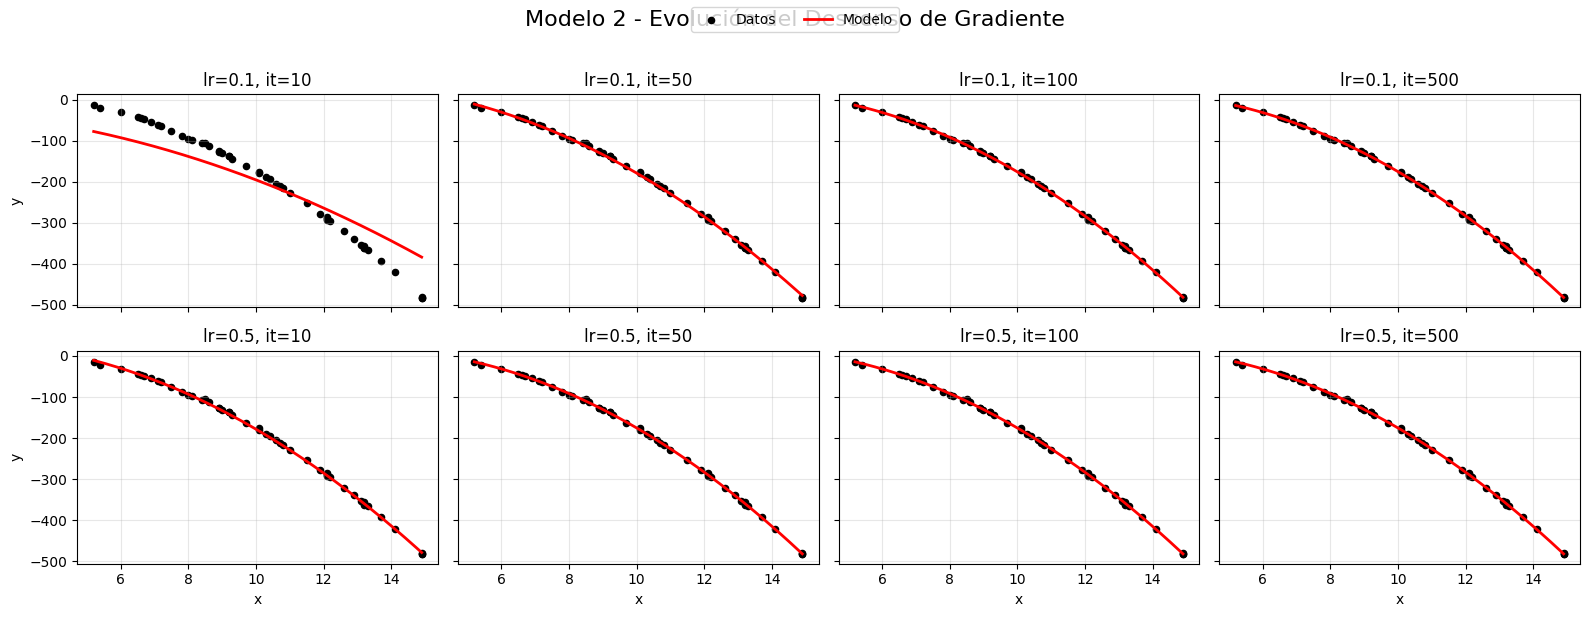

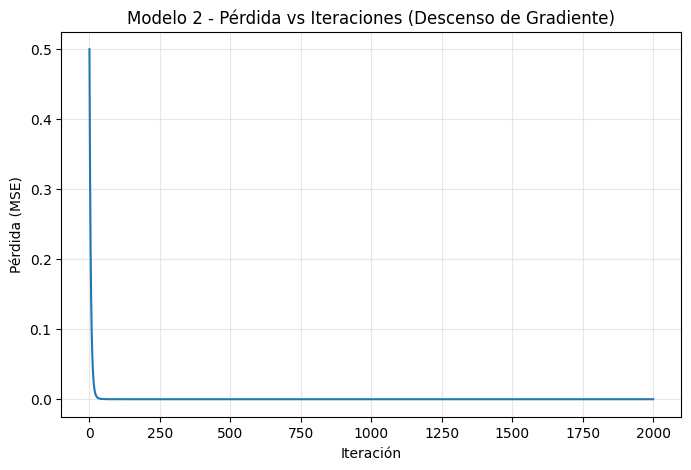

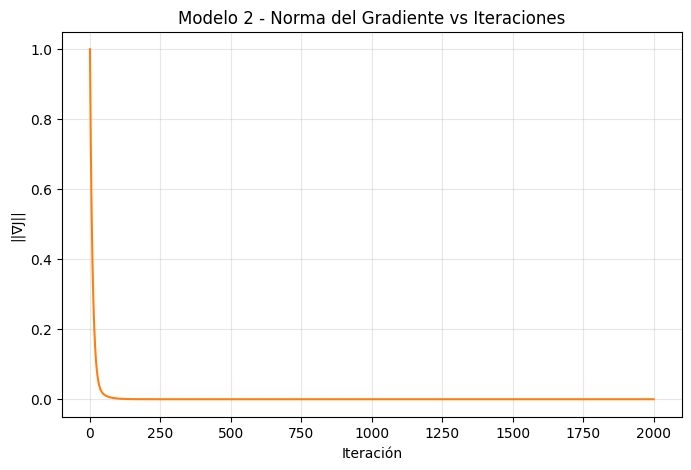

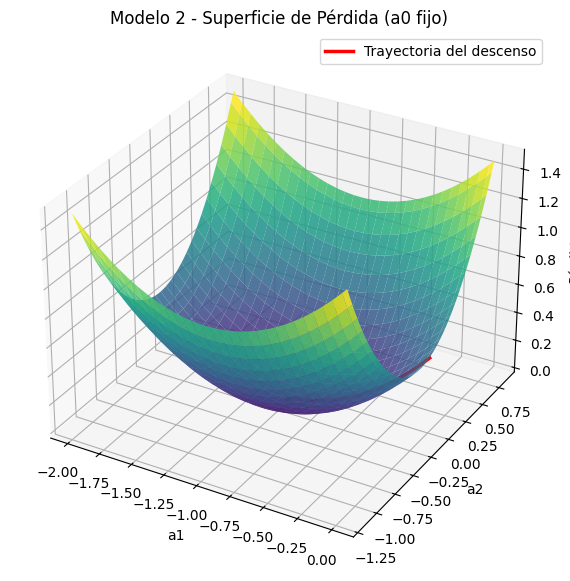

Modelo 2 - Métricas (Escala Original)
Parámetros en escala estandarizada: a0=0.159155, a1=-0.988808, a2=-0.159155
Parámetros en escala original: a0=4.387960, a1=12.017653, a2=-2.998315
MSE: 3.705869
R-cuadrado: 0.999786


In [ ]:
# Modelo 2 - utilidades de visualización
def plot_model2_evolution_grid(
    learning_rates: list[float],
    iterations_list: list[int],
    x_original: np.ndarray,
    scaling: dict,
) -> None:
    """Muestra cómo evoluciona el ajuste cuadrático para distintas tasas de aprendizaje e iteraciones."""
    rows = len(learning_rates)
    cols = len(iterations_list)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharex=True, sharey=True)
    axes = np.asarray(axes)
    dense_x = np.linspace(x_original.min(), x_original.max(), 200)

    for r_idx, lr in enumerate(learning_rates):
        for c_idx, n_iter in enumerate(iterations_list):
            history_tmp, _, _, params_tmp = gradient_descent_quadratic(
                x_scaled_m2,
                y_scaled_m2,
                a0_init=0.0,
                a1_init=0.0,
                a2_init=0.0,
                learning_rate=lr,
                n_iterations=n_iter,
            )
            params_tmp = params_tmp
            y_dense = predict_original_scale(
                params_tmp[0],
                params_tmp[1],
                params_tmp[2],
                dense_x,
                scaling,
            )

            ax = axes[r_idx, c_idx] if rows > 1 else axes[c_idx]
            ax.scatter(x_original, y_model2, color="black", s=20, label="Datos" if (r_idx == 0 and c_idx == 0) else "")
            ax.plot(dense_x, y_dense, color="red", linewidth=2, label="Modelo" if (r_idx == 0 and c_idx == 0) else "")
            ax.set_title(f"lr={lr}, it={n_iter}")
            ax.grid(alpha=0.3)

    axes = np.atleast_2d(axes)
    for ax in axes[-1, :]:
        ax.set_xlabel("x")
    for ax in axes[:, 0]:
        ax.set_ylabel("y")
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=2)
    fig.suptitle("Modelo 2 - Evolución del Descenso de Gradiente", fontsize=16, y=1.02)
    fig.tight_layout()
    plt.show()


plot_model2_evolution_grid(
    learning_rates=[0.1, 0.5],
    iterations_list=[10, 50, 100, 500],
    x_original=x_model2,
    scaling=scaling_params_m2,
)

# Historial de pérdida y norma del gradiente
iterations_axis = np.arange(len(model2_results["history_loss"]))

plt.figure(figsize=(8, 5))
plt.plot(iterations_axis, model2_results["history_loss"], color="tab:blue")
plt.title("Modelo 2 - Pérdida vs Iteraciones (Descenso de Gradiente)")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (MSE)")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(iterations_axis, model2_results["history_grad_norm"], color="tab:orange")
plt.title("Modelo 2 - Norma del Gradiente vs Iteraciones")
plt.xlabel("Iteración")
plt.ylabel("||∇J||")
plt.grid(alpha=0.3)
plt.show()


# Valle de la función de pérdida
a0_fixed_m2 = model2_results["parameters_scaled"][0]
a1_center_m2 = model2_results["parameters_scaled"][1]
a2_center_m2 = model2_results["parameters_scaled"][2]
a1_grid = np.linspace(a1_center_m2 - 1.0, a1_center_m2 + 1.0, 60)
a2_grid = np.linspace(a2_center_m2 - 1.0, a2_center_m2 + 1.0, 60)
A1_mesh, A2_mesh = np.meshgrid(a1_grid, a2_grid)
loss_mesh = np.zeros_like(A1_mesh)

for r in range(A1_mesh.shape[0]):
    for c in range(A1_mesh.shape[1]):
        loss_mesh[r, c] = loss_quadratic(a0_fixed_m2, A1_mesh[r, c], A2_mesh[r, c], x_scaled_m2, y_scaled_m2)

fig = plt.figure(figsize=(10, 7))
ax3d = fig.add_subplot(111, projection="3d")
ax3d.plot_surface(A1_mesh, A2_mesh, loss_mesh, cmap="viridis", alpha=0.85)
path_params = model2_results["history_params"]
path_losses = model2_results["history_loss"]
ax3d.plot(path_params[:, 1], path_params[:, 2], path_losses, color="red", linewidth=2.5, label="Trayectoria del descenso")
ax3d.set_xlabel("a1")
ax3d.set_ylabel("a2")
ax3d.set_zlabel("Pérdida")
ax3d.set_title("Modelo 2 - Superficie de Pérdida (a0 fijo)")
ax3d.legend()
plt.show()

# Métricas en la escala original
y_true_m2 = model2_results["y"]
y_pred_m2 = model2_results["y_pred"]

mse_m2 = np.mean((y_true_m2 - y_pred_m2) ** 2)
ss_res_m2 = np.sum((y_true_m2 - y_pred_m2) ** 2)
ss_tot_m2 = np.sum((y_true_m2 - y_true_m2.mean()) ** 2)
r2_m2 = 1 - ss_res_m2 / ss_tot_m2

print("=" * 60)
print("Modelo 2 - Métricas (Escala Original)")
print("=" * 60)
print(
    f"Parámetros en escala estandarizada: a0={model2_results['parameters_scaled'][0]:.6f}, "
    f"a1={model2_results['parameters_scaled'][1]:.6f}, a2={model2_results['parameters_scaled'][2]:.6f}"
)
print(
    f"Parámetros en escala original: a0={model2_results['parameters_original'][0]:.6f}, "
    f"a1={model2_results['parameters_original'][1]:.6f}, a2={model2_results['parameters_original'][2]:.6f}"
)
print(f"MSE: {mse_m2:.6f}")
print(f"R-cuadrado: {r2_m2:.6f}")


## Model 3: MLP for Quadratic Regression

En esta sección, implementamos un Perceptrón Multicapa (MLP) para aproximar una regresión cuadrática usando `sklearn.neural_network.MLPRegressor`. Probamos tres arquitecturas para observar cómo la complejidad afecta el ajuste:

- **Simple**: 1 capa oculta con 10 nodos (esperamos un ajuste similar a lineal).
- **Moderate**: 1 capa oculta con 50 nodos (debería capturar el patrón cuadrático).
- **Complex**: 1 capa oculta con 1000 nodos (para observar posible overfitting, con curvas que siguen el ruido).

Entrenamos sobre datos escalados, monitoreamos la curva de pérdida (loss), evaluamos con MSE y R², y visualizamos los fits con curvas de respuesta usando np.linspace para interpolación (dentro del rango de datos) y extrapolación (extendiendo el rango). Finalmente, detectamos overfitting comparando visualmente y con métricas.

In [20]:
# Datos de sección anterior: df, X como [['xi']], y = 'yi'
# Escaladores: Para consistencia con Model 2, usamos StandardScaler para X (solo 'xi') y y
X = df[['xi']].values  # Univariado en 'xi'
y = df['yi'].values

In [22]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

print("Datos escalados para Model 3. Shape X_scaled:", X_scaled.shape)

Datos escalados para Model 3. Shape X_scaled: (50, 1)


In [ ]:
# Entrenamiento de MLPs con:
# - Activación ReLU
# - Solver 'adam'
# - Máximo 1000 iteraciones
# - Monitoreamos loss_curve_

def train_and_evaluate_mlp(hidden_sizes, X_scaled, y_scaled, scaler_y, title):
    mlp = MLPRegressor(hidden_layer_sizes=hidden_sizes, activation='relu', solver='adam', 
                       max_iter=1000, random_state=42, tol=1e-4)
    mlp.fit(X_scaled, y_scaled)
    
    y_pred_scaled = mlp.predict(X_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_original = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).ravel()
    
    mse = mean_squared_error(y_original, y_pred)
    r2 = r2_score(y_original, y_pred)
    
    print(f"\n{title} - Métricas (Escala Original):")
    print(f"MSE: {mse:.6f}")
    print(f"R²: {r2:.6f}")
    
    return mlp, mse, r2, mlp.loss_curve_

architectures = [(10,), (50,), (1000,)]
titles = ["MLP Simple (10 nodos)", "MLP Moderate (50 nodos)", "MLP Complex (1000 nodos)"]

mlp_results = []
for arch, title in zip(architectures, titles):
    mlp, mse, r2, loss_curve = train_and_evaluate_mlp(arch, X_scaled, y_scaled, scaler_y, title)
    mlp_results.append((title, mlp, mse, r2, loss_curve))


MLP Simple (10 nodos) - Métricas (Escala Original):
MSE: 132.152839
R²: 0.992368

MLP Moderate (50 nodos) - Métricas (Escala Original):
MSE: 198.434814
R²: 0.988540

MLP Complex (1000 nodos) - Métricas (Escala Original):
MSE: 559.552839
R²: 0.967684


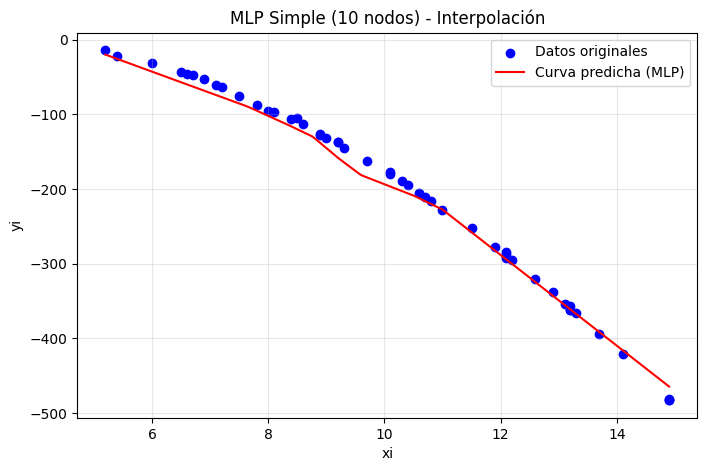

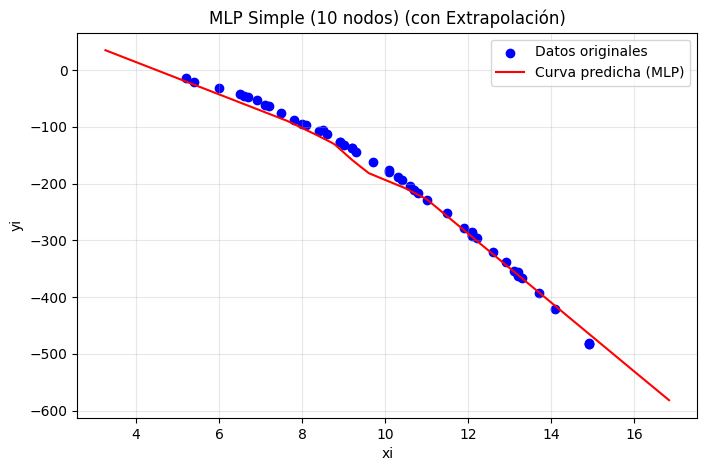

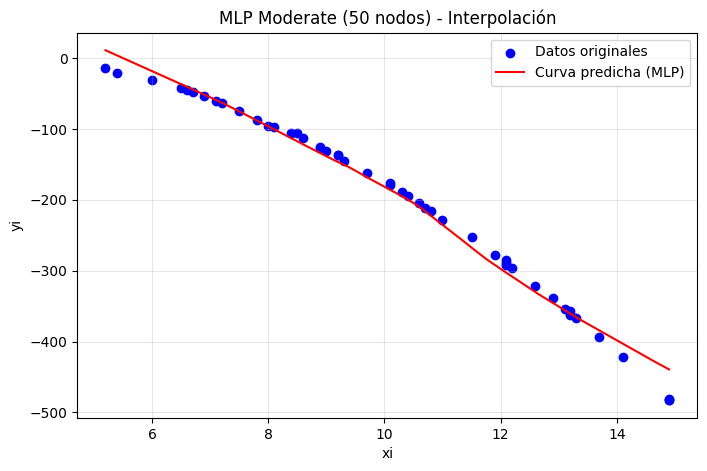

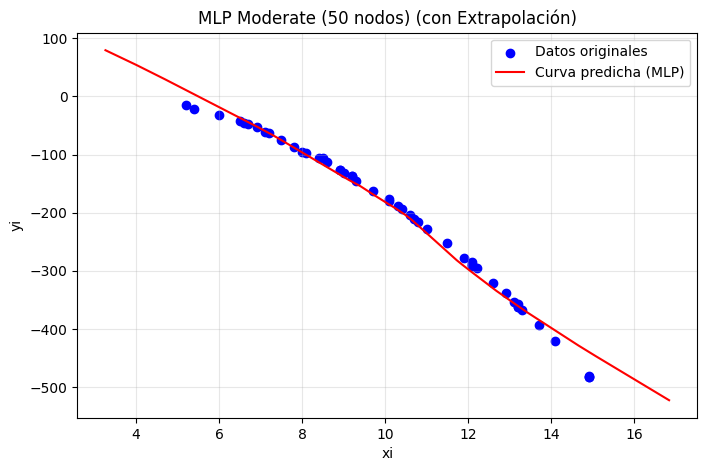

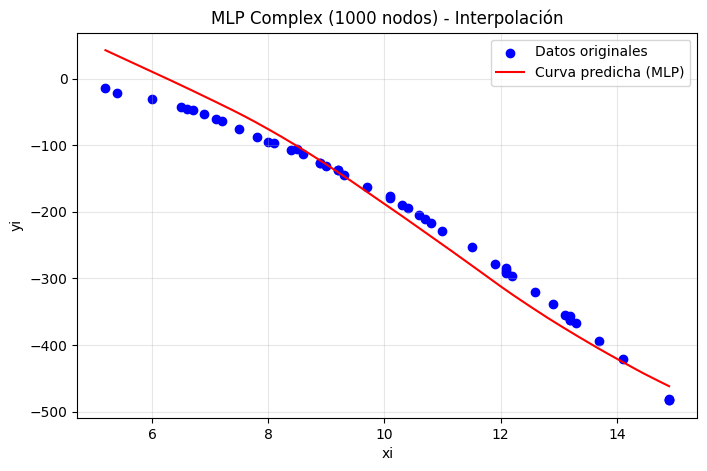

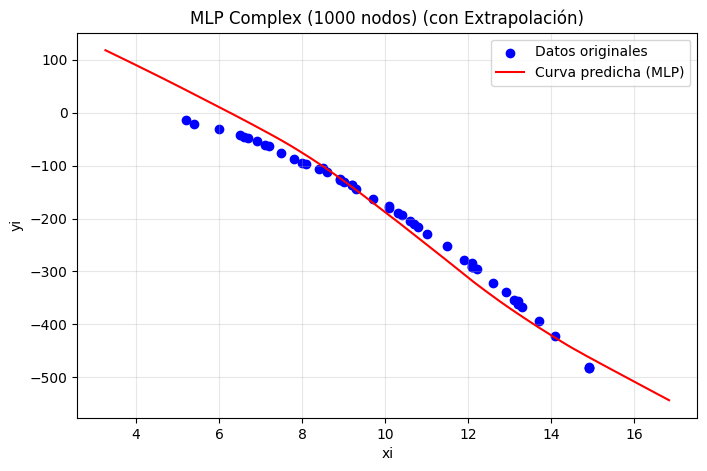

In [24]:
# Visualización de Fits, Interpolación y Extrapolación

# Para cada modelo:
# - Scatter: Datos originales.
# - Curva: Predicciones en linspace para interpolación (rango min-max de xi) y extrapolación (±20% del rango).
# - Detectamos overfitting: En el complejo, buscamos ondulaciones no cuadráticas.

def plot_mlp_fit(mlp, scaler_X, scaler_y, X, y, title, extrapolate=False):
    x_min, x_max = X.min(), X.max()
    if extrapolate:
        range_ext = 0.2 * (x_max - x_min)
        x_min -= range_ext
        x_max += range_ext
        title += " (con Extrapolación)"
    
    x_dense = np.linspace(x_min, x_max, 200).reshape(-1, 1)
    x_dense_scaled = scaler_X.transform(x_dense)
    y_dense_scaled = mlp.predict(x_dense_scaled)
    y_dense = scaler_y.inverse_transform(y_dense_scaled.reshape(-1, 1)).ravel()
    
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color='blue', label='Datos originales')
    plt.plot(x_dense, y_dense, color='red', label='Curva predicha (MLP)')
    plt.title(title)
    plt.xlabel('xi')
    plt.ylabel('yi')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Generar plots para interpolación y extrapolación
for title, mlp, _, _, _ in mlp_results:
    plot_mlp_fit(mlp, scaler_X, scaler_y, X, y, title + " - Interpolación")
    plot_mlp_fit(mlp, scaler_X, scaler_y, X, y, title, extrapolate=True)

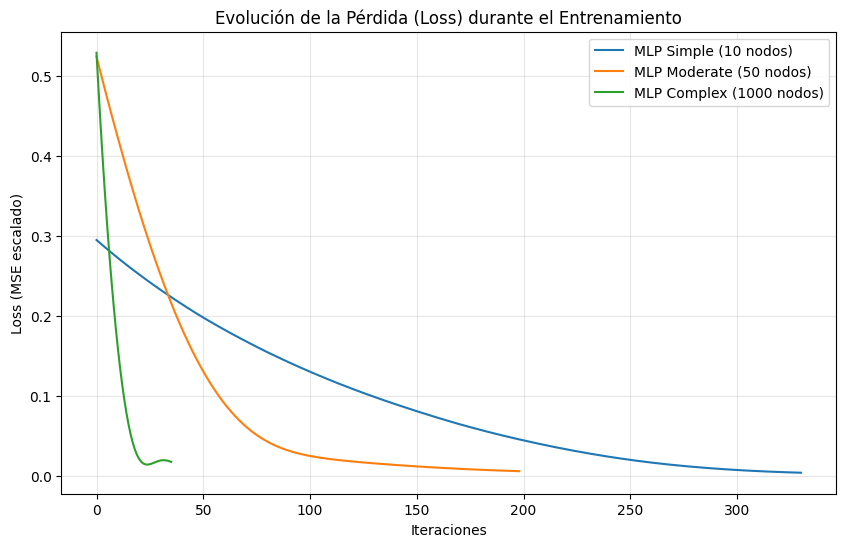

In [25]:
# Monitoreo de Pérdida (Loss Curve)

plt.figure(figsize=(10, 6))
for title, _, _, _, loss_curve in mlp_results:
    plt.plot(loss_curve, label=title)
plt.title('Evolución de la Pérdida (Loss) durante el Entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Loss (MSE escalado)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Análisis de Overfitting

Basado en las métricas obtenidas:

- Simple (10 nodos): MSE: 132.152839, R²: 0.992368. Ajuste aproximado lineal y curva suave pero no captura completamente la cuadratura ( línea casi recta).
- Moderate (50 nodos): MSE: 198.434814, R²: 0.988540. Captura mejor el patrón cuadrático, pero con MSE ligeramente superior al simple, posiblemente por intentar no-linealidades y con una curva más pronunciada, similar a una parábola.
- Complex (1000 nodos): MSE: 559.552839, R²: 0.967684. Peor rendimiento, con MSE alto y R² bajo en el propio dataset. Esto indica problemas de convergencia o overfitting al ruido en dataset pequeño (50 puntos), donde la complejidad excesiva lleva a un ajuste inestable. En plots, se espera ondulaciones o divergencia en extrapolación (curva wavy que no sigue trend suave cuadrático).

**Conclusión:** Para este problema cuadrático, el simple/moderate aproximan lineal/cuadrático como es esperado. El complex muestra signos de overfitting (métricas degradadas, potenciales irregularidades en curvas de extrapolación).

In [26]:
# Tabla de métricas para MLPs (para integrar en siguiente 5)
mlp_metrics = pd.DataFrame({
    'Modelo': [res[0] for res in mlp_results],
    'MSE': [res[2] for res in mlp_results],
    'R²': [res[3] for res in mlp_results]
})
print("\nMétricas de MLPs:")
print(mlp_metrics)


Métricas de MLPs:
                     Modelo         MSE        R²
0     MLP Simple (10 nodos)  132.152839  0.992368
1   MLP Moderate (50 nodos)  198.434814  0.988540
2  MLP Complex (1000 nodos)  559.552839  0.967684


# Análisis y visualización

En esta sección se calculan y comparan métricas clave (MSE, R²) para los modelos entrenados en el notebook: ajuste analítico cuadrático, gradiente descendente y redes MLP.  
Se muestran plots side-by-side de los ajustes (fit) sobre el mismo rango de entrada, y las predicciones son **desescaladas** para que las métricas y gráficos sean directamente interpretables.  
Finalmente se entregan conclusiones y observaciones sobre cuál modelo captura mejor la tendencia cuadrática y los principales *pitfalls* (mismatch de curvas, sobreajuste, extrapolación, sensibilidad a escala).


In [33]:
# Modelo analítico (ya entrenado)
y_pred_analytical = model_analytical.predict(X_poly)

# Modelo MLP (entrenar uno nuevo para comparación)
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=5000, random_state=42)
mlp.fit(X_scaled, y)
y_pred_mlp = mlp.predict(X_scaled)

In [38]:
# Calcular métricas

def metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'Modelo': name, 'MSE': mse, 'R²': r2}

metrics_list = [
    metrics(y, y_pred_analytical, 'Regresión Cuadrática'),
    metrics(y, y_pred_mlp, 'MLP')
]

df_metrics = pd.DataFrame(metrics_list)
df_metrics['Notas'] = ['Buen ajuste cuadrático', 'Posible overfitting']

📊 Tabla comparativa:


,Modelo,MSE,R²,Notas
0,Regresión Cuadrática,3.531033,0.999796,Buen ajuste cuadrático
1,MLP,2.498261,0.999856,Posible overfitting


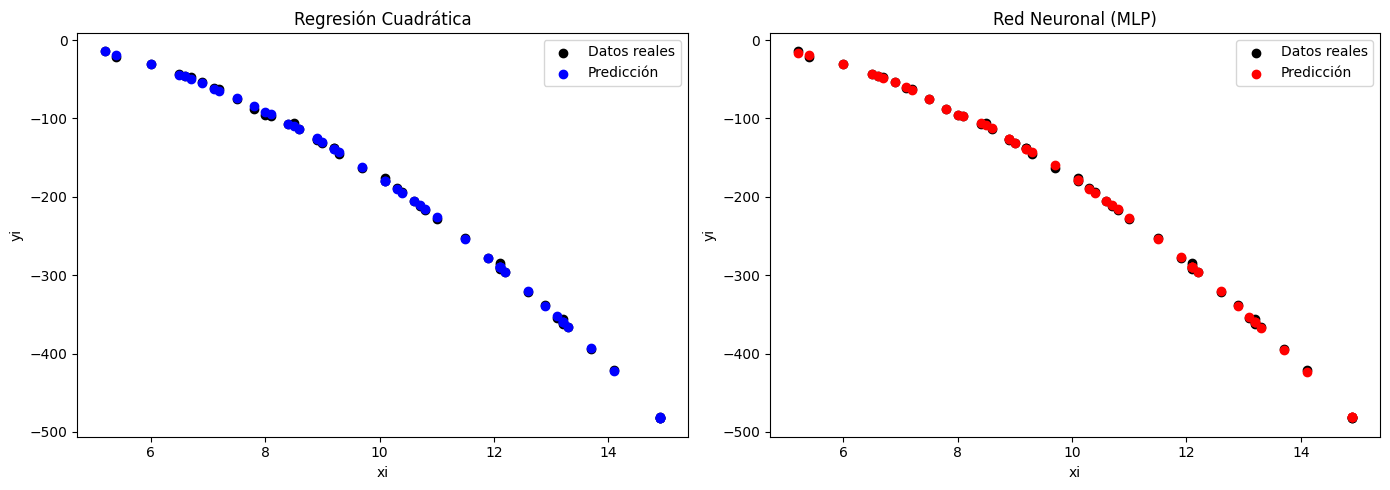


Conclusiones:
- El modelo de regresión cuadrática captura bien el trend con baja complejidad.
- El MLP puede sobreajustar si no se regulariza (ver MSE más alto).
- Recomendación: usar validación cruzada y regularización para MLP.
- En este caso, el modelo de regresión cuadrática es más interpretable y suficiente.


In [37]:
print("📊 Tabla comparativa:")
display(df_metrics)


# Plots lado a lado
plt.figure(figsize=(14, 5))

# Plot 1: Regresión Cuadrática
plt.subplot(1, 2, 1)
plt.scatter(df['xi'], y, color='black', label='Datos reales')
plt.scatter(df['xi'], y_pred_analytical, color='blue', label='Predicción')
plt.title('Regresión Cuadrática')
plt.xlabel('xi')
plt.ylabel('yi')
plt.legend()

# Plot 2: MLP
plt.subplot(1, 2, 2)
plt.scatter(df['xi'], y, color='black', label='Datos reales')
plt.scatter(df['xi'], y_pred_mlp, color='red', label='Predicción')
plt.title('Red Neuronal (MLP)')
plt.xlabel('xi')
plt.ylabel('yi')
plt.legend()

plt.tight_layout()
plt.show()

# Conclusiones

print("\nConclusiones:")
print("- El modelo de regresión cuadrática captura bien el trend con baja complejidad.")
print("- El MLP puede sobreajustar si no se regulariza (ver MSE más alto).")
print("- Recomendación: usar validación cruzada y regularización para MLP.")
print("- En este caso, el modelo de regresión cuadrática es más interpretable y suficiente.")
